# nuSQuIDS for atmospheric oscillations with Layers
-------------------
Here, we develop the concrete implementation of atmospheric oscillations using the `nuSQUIDSLayers` class and PISA's `Layers` module. This development will go into the implementation of the PISA stage.

In [1]:
%matplotlib inline
import os, sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
# plt.style.use('dark_background')

In [2]:
from pisa.stages.osc.layers import Layers
from pisa import ureg

earth_model = "/afs/ifh.de/user/t/trettin/scratch/pisa/pisa_examples/resources/osc/PREM_12layer.dat"
# electron densities
YeI = 0.4656
YeM = 0.4957
YeO = 0.4656

# height (units are assumed to be km by layers module)
detector_depth = 2. # * ureg["km"]
prop_height = 20. # * ureg["km"]

layers = Layers(earth_model, detector_depth, prop_height)
layers.setElecFrac(1, 1, 1)

<< PISA_TARGET env var is defined as: "cpu"; PISA is running in double precision (FP64) mode; numba is running on CPU (single core) >>


In [3]:
tot_len_calculator = Layers(None, detector_depth, 10.)
tot_len_calculator.calcPathLength(0.2)
print(tot_len_calculator.distance)

tot_len_calculator = Layers(None, detector_depth, 100.)
tot_len_calculator.calcPathLength(0.2)
print(tot_len_calculator.distance)


[58.70382363]
[438.58034326]


In [4]:
import nuSQUIDSpy as nsq

units = nsq.Const()

def make_nus_layer(e_nodes, coszen_nodes, n_flavors, return_tot_lens=False, nu_type=nsq.NeutrinoType.neutrino):
    # convert lists to ndarrays and scalars to ndarrays with length 1
    e_nodes = np.atleast_1d(e_nodes)
    coszen_nodes = np.atleast_1d(coszen_nodes)
    
    # broadcast against each other and make a copy
    # (see https://numpy.org/doc/stable/reference/generated/numpy.broadcast_arrays.html)
    e_nodes, coszen_nodes = [np.array(a) for a in np.broadcast_arrays(e_nodes, coszen_nodes)]
    
    assert e_nodes.ndim == 1, "arrays must be flat"
    assert coszen_nodes.ndim == 1, "arrays must be flat"
    assert len(e_nodes) == len(coszen_nodes)
    
    layers.calcLayers(coszen_nodes)
    distances = np.reshape(
        layers.distance,
        (len(e_nodes), layers.max_layers),
    )
    densities = np.reshape(
        layers.density,
        (len(e_nodes), layers.max_layers),
    )
    ye = np.zeros_like(densities)
    ye[densities < 10] = YeM
    ye[(densities >= 10) & (densities < 13)] = YeO
    ye[densities >= 13] = YeI
    nus_layer = nsq.nuSQUIDSLayers(
        distances*units.km,
        densities,
        ye,
        e_nodes,
        n_flavors,
        nu_type,
    )
    
    if return_tot_lens:
        tot_lens = np.sum(distances, axis=1) * units.km  # total times
        return nus_layer, tot_lens
    else:
        return nus_layer

In [5]:
# e_nodes = np.geomspace(5, 150, 50)*units.GeV
e_nodes = np.concatenate(
    (
        np.geomspace(1, 2, 5, endpoint=False),
        np.geomspace(2, 10, 25, endpoint=False),
        #np.geomspace(10, 300, 10, endpoint=False),
        np.geomspace(10, 10000, 25)
    )
) * units.GeV
# e_nodes = np.geomspace(1, 10000, 401) * units.GeV
#e_nodes = np.sort(np.concatenate((e_nodes[e_nodes < 150], [150]))) * units.GeV

cosz_nodes = np.concatenate(
    (
        np.linspace(-1, -0.85, 10, endpoint=False),
        np.linspace(-0.85, -0.825, 10, endpoint=False),
        np.linspace(-0.825, 0, 25, endpoint=False),
        np.linspace(0, 1, 5),
    )
)


# remove duplicates, make array, sort
# cosz_nodes = np.sort(np.array(list(set(cosz_nodes))))

# cosz_nodes = np.concatenate((cosz_nodes[cosz_nodes < 0.2], [0.2]))
# cosz_nodes = np.linspace(-1., 1, 400)
e_mesh, cosz_mesh = np.meshgrid(e_nodes, cosz_nodes)

In [6]:
from scipy import interpolate

e_plot = np.geomspace(1, 500, 1000)*units.GeV
cosz_plot = np.linspace(-1., 0.0, 1001)

def get_probs(th24=0, th34=0, dcp24=0, flav_out=1, flav_in=1, n_flav=4):
    nus_layer, tot_lens = make_nus_layer(
        e_mesh.ravel(), cosz_mesh.ravel(), n_flav,
        nu_type=nsq.NeutrinoType.neutrino,
        return_tot_lens=True
    )
    nus_layer.Set_MixingParametersToDefault()
    nus_layer.Set_SquareMassDifference(3, 1)
    nus_layer.Set_CPPhase(2, 3, dcp24)
    nus_layer.Set_MixingAngle(1, 3, th24 * np.pi/180)
    nus_layer.Set_MixingAngle(2, 3, th34 * np.pi/180)
    
    initial_state = np.array([0] * n_flav)
    initial_state[flav_in] = 1
    
    nus_layer.Set_initial_state(initial_state, nsq.Basis.flavor)
    nus_layer.Set_rel_error(1.0e-6)
    nus_layer.Set_abs_error(1.0e-6)
    nus_layer.Set_EvolLowPassCutoff(0.1 / units.km)
    nus_layer.Set_EvolLowPassScale(0.1 * 0.1 / units.km)
    nus_layer.EvolveState()
    # avg_cutoff = 50
    # avg_scale = 20

    # minimum and maximum production height
    # Oscillation probabilities are averaged by assuming uniform distribution over
    # the entire distance through the atmosphere
    min_prod_height = 10.  # in km
    max_prod_height = 30.  # in km

    avg_height = True
    lp_filter_cutoff = 0.0  # 0.005 / units.km  # 200./12000./units.km
    lp_filter_scale = 0.0  # 0.5 * lp_filter_cutoff  # 50./12000./units.km
    

    layers.calcLayers(cosz_plot)
    distances = np.reshape(
        layers.distance, (cosz_plot.size, layers.max_layers))
    tot_lens = np.sum(distances, axis=1) * units.km

    evolved_states = nus_layer.GetStates()
    interp_states = np.zeros(
        (e_plot.size * cosz_plot.size, evolved_states.shape[1]))

    e_plot_mesh, cosz_plot_mesh = np.meshgrid(e_plot, cosz_plot)
    e_plot_mesh, tot_lens_mesh = np.meshgrid(e_plot, tot_lens)

    for i in range(evolved_states.shape[1]):
        z = evolved_states[:, i].reshape(e_mesh.shape).T
        f = interpolate.RectBivariateSpline(
            np.log10(e_nodes), cosz_nodes, z, kx=2, ky=2)
        interp_states[..., i] = f(
            np.log10(e_plot_mesh.ravel()), cosz_plot_mesh.ravel(), grid=False)

    lp_filter_belowhor = lp_filter_cutoff * np.ones_like(e_plot_mesh.ravel())
    lp_filter_belowhor[cosz_plot_mesh.ravel() > 0] = 0
    lp_scale_belowhor = lp_filter_belowhor * 0.5

    if avg_height:
        min_len_calculator = Layers(None, detector_depth, min_prod_height)
        max_len_calculator = Layers(None, detector_depth, max_prod_height)
        # not super efficient to do it on the mesh like this, but oh well...
        min_len_calculator.calcPathLength(cosz_plot_mesh.ravel())
        max_len_calculator.calcPathLength(cosz_plot_mesh.ravel())
        min_lens = min_len_calculator.distance * units.km
        max_lens = max_len_calculator.distance * units.km
        # the nuSQuIDS function assumes that the given time is the end of the
        # interval and the range is the length of the interval.
        len_ranges = max_lens - min_lens
        assert np.all(len_ranges > 0.)

        # len_ranges[cosz_plot_mesh.ravel() < 0] = 0.

        prob_interp = nus_layer.EvalWithState(
            flav_out,
            tot_lens_mesh.ravel(), e_plot_mesh.ravel(), interp_states,
            rho=0,
            avg_cutoff=0,
            avg_scale=0,
            t_range=len_ranges,
            lowpass_cutoff=lp_filter_belowhor,
            lowpass_scale=lp_scale_belowhor,
        )
    else:
        prob_interp = nus_layer.EvalWithState(
            flav_out,
            tot_lens_mesh.ravel(), e_plot_mesh.ravel(), interp_states,
            rho=0,
            avg_cutoff=0,
            avg_scale=0,
            t_range=np.zeros_like(tot_lens_mesh.ravel()),
            lowpass_cutoff=lp_filter_belowhor,
            lowpass_scale=lp_scale_belowhor,
        )
    prob_interp = prob_interp.reshape(e_plot_mesh.shape)

    return prob_interp, nus_layer

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:27: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



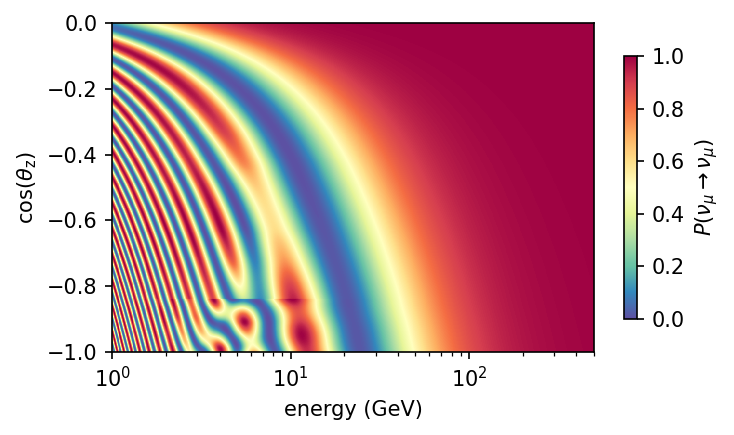

In [7]:
from matplotlib.colors import Normalize
import tikzplotlib

flav_in = "mu"
flav_out = "mu"

flav_idx = {
    "e": 0,
    "mu": 1,
    "tau": 2,
    "s": 3
}
flav_tex = {
    "e": "e",
    "mu": "\\mu",
    "tau": "\\tau",
    "s": "s"
}

probs, nus_obj = get_probs(
    th24=0, th34=0, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=3
)

plt.figure(figsize=(5, 3))
plt.pcolormesh(
    e_plot/units.GeV, cosz_plot, probs,
    norm=Normalize(vmin=0, vmax=1), cmap="Spectral_r"
)
# mask = prob_interp < 0
# e_below = e_plot_mesh[mask]/units.GeV
# cs_below = cosz_plot_mesh[mask]
# plt.scatter(e_below, cs_below, marker=".", color="red", label="probs lt 0")
# plt.scatter(e_mesh/units.GeV, cosz_mesh, label="nodes", marker=".", color="k", s=2)
# plt.axhline(y=-0.84, lw=1)
plt.semilogx()
cbar = plt.colorbar(shrink=0.8)
# cbar.set_label(r"$P(\bar{\nu}_\mu\rightarrow\bar{\nu}_\mu)$")

cbar.set_label(fr"$P(\nu_{flav_tex[flav_in]}\rightarrow\nu_{flav_tex[flav_out]})$")
plt.xlabel("energy (GeV)")
plt.ylabel(r"$\cos(\theta_{\mathrm{z}})$")
plt.tight_layout()
# plt.title("muon neutrino survival probability")
# plt.xlim((np.min(e_mesh/units.GeV), np.max(e_mesh/units.GeV)))
# plt.ylim((np.min(cosz_mesh), np.max(cosz_mesh)))


plt.xlim((1, 500))
plt.ylim((-1, 0))
plt.tight_layout()
th24 = np.rad2deg(nus_obj.Get_MixingAngle(1, 3))
th34 = np.rad2deg(nus_obj.Get_MixingAngle(2, 3))
dm31 = nus_obj.Get_SquareMassDifference(2)
dm41 = nus_obj.Get_SquareMassDifference(3)

# plt.text(
#     .6, .9,
#     #fr"$\Delta m^2_{{31}}={nus_layer.Get_SquareMassDifference(2)*1e3:.4g}\times10^{{-3}}\,\mathrm{{eV^2}}$"+"\n"
#     fr"$\Delta m^2_{{41}}={dm41:.0f}\,\mathrm{{eV^2}}$"+"\n"
#     # fr"$\theta_{{23}}={np.rad2deg(nus_layer.Get_MixingAngle(1,2)):.4g}^\circ$"+"\n"
#     fr"$\theta_{{24}}={th24:.0f}^\circ$"+"\n"
#     fr"$\theta_{{34}}={th34:.0f}^\circ$",
#     verticalalignment="top",
#     fontsize="smaller",
#     transform=plt.gca().transAxes,
#     bbox=dict(facecolor='white', alpha=0.5, boxstyle="round")
# )

plt.tight_layout()
# plt.savefig(
#     # f"figures_apc_may_22/numu_surv_prob_dm41_1eV2_th24_{th24:.2g}_th34_{th34:.2g}.png",
#     "figures_apc_may_22/numu_surv_prob_no_sterile_no_text_wide_e.png",
#     dpi=300
# )
# tikzplotlib.save("figures_apc_may_22/numu_surv_prob_no_sterile_no_text_wide_e.tex", dpi=300)

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



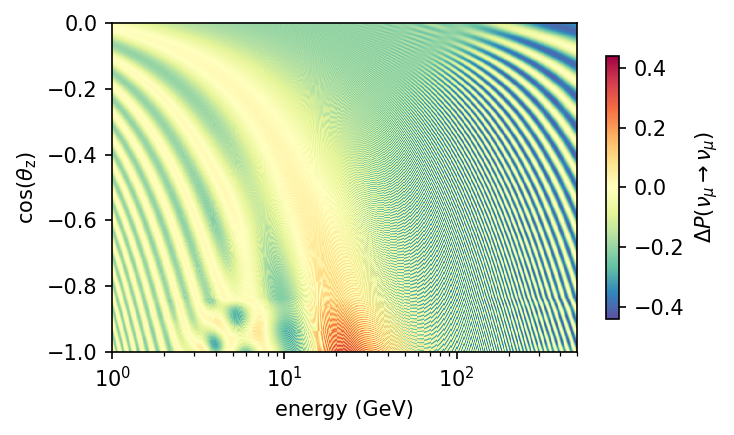

In [18]:
from matplotlib.colors import Normalize
import tikzplotlib

flav_in = "mu"
flav_out = "mu"

flav_idx = {
    "e": 0,
    "mu": 1,
    "tau": 2,
    "s": 3
}
flav_tex = {
    "e": "e",
    "mu": "\\mu",
    "tau": "\\tau",
    "s": "s"
}

probs_null, nus_obj = get_probs(
    th24=0, th34=0, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=3
)

probs_alt, nus_obj = get_probs(
    th24=20, th34=0, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=4
)

prob_ratio = probs_alt - probs_null
amp = np.max([-np.min(prob_ratio), np.max(prob_ratio)])

plt.figure(figsize=(5, 3))
plt.pcolormesh(
    e_plot/units.GeV, cosz_plot, prob_ratio,
    norm=Normalize(vmin=-amp, vmax=amp), cmap="Spectral_r",
    rasterized=True  # rasterize plot to avoid huge PDF file
)

plt.semilogx()
cbar = plt.colorbar(shrink=0.8)

cbar.set_label(fr"$\Delta P(\nu_{flav_tex[flav_in]}\rightarrow\nu_{flav_tex[flav_out]})$")
plt.xlabel("energy (GeV)")
plt.ylabel(r"$\cos(\theta_{\mathrm{z}})$")
plt.tight_layout()
plt.savefig("figures_nnn23/delta_prob_th24_20deg.pdf")

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



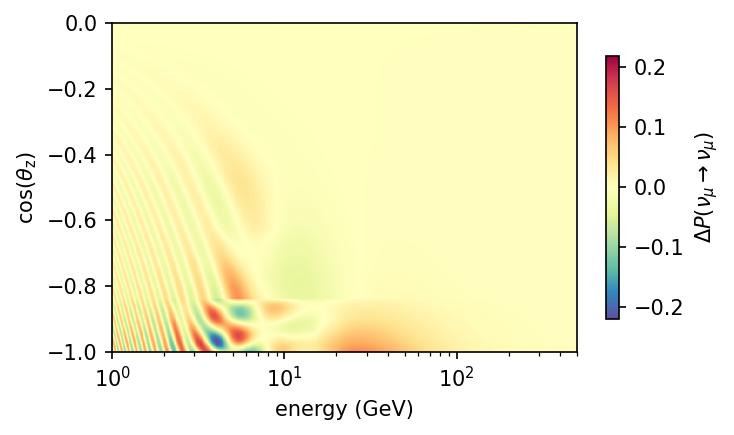

In [19]:
from matplotlib.colors import Normalize
import tikzplotlib

flav_in = "mu"
flav_out = "mu"

flav_idx = {
    "e": 0,
    "mu": 1,
    "tau": 2,
    "s": 3
}
flav_tex = {
    "e": "e",
    "mu": "\\mu",
    "tau": "\\tau",
    "s": "s"
}

probs_null, nus_obj = get_probs(
    th24=0, th34=0, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=3
)

probs_alt, nus_obj = get_probs(
    th24=0, th34=20, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=4
)

prob_ratio = probs_alt - probs_null
amp = np.max([-np.min(prob_ratio), np.max(prob_ratio)])

plt.figure(figsize=(5, 3))
plt.pcolormesh(
    e_plot/units.GeV, cosz_plot, prob_ratio,
    norm=Normalize(vmin=-amp, vmax=amp), cmap="Spectral_r",
    rasterized=True  # rasterize plot to avoid huge PDF file
)

plt.semilogx()
cbar = plt.colorbar(shrink=0.8)

cbar.set_label(fr"$\Delta P(\nu_{flav_tex[flav_in]}\rightarrow\nu_{flav_tex[flav_out]})$")
plt.xlabel("energy (GeV)")
plt.ylabel(r"$\cos(\theta_{\mathrm{z}})$")
plt.tight_layout()
plt.savefig("figures_nnn23/delta_prob_th34_20deg.pdf")

[ WARNING] /afs/ifh.de/group/amanda/scratch/trettin/fridge3/pyenv3.7/lib/python3.7/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.



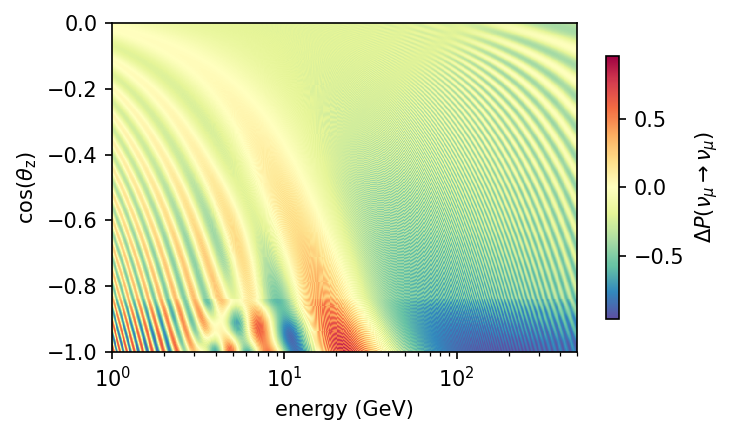

In [20]:
from matplotlib.colors import Normalize
import tikzplotlib

flav_in = "mu"
flav_out = "mu"

flav_idx = {
    "e": 0,
    "mu": 1,
    "tau": 2,
    "s": 3
}
flav_tex = {
    "e": "e",
    "mu": "\\mu",
    "tau": "\\tau",
    "s": "s"
}

probs_null, nus_obj = get_probs(
    th24=0, th34=0, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=3
)

probs_alt, nus_obj = get_probs(
    th24=20, th34=20, flav_out=flav_idx[flav_out], flav_in=flav_idx[flav_in], n_flav=4
)

prob_ratio = probs_alt - probs_null
amp = np.max([-np.min(prob_ratio), np.max(prob_ratio)])

plt.figure(figsize=(5, 3))
plt.pcolormesh(
    e_plot/units.GeV, cosz_plot, prob_ratio,
    norm=Normalize(vmin=-amp, vmax=amp), cmap="Spectral_r",
    rasterized=True  # rasterize plot to avoid huge PDF file
)

plt.semilogx()
cbar = plt.colorbar(shrink=0.8)

cbar.set_label(fr"$\Delta P(\nu_{flav_tex[flav_in]}\rightarrow\nu_{flav_tex[flav_out]})$")
plt.xlabel("energy (GeV)")
plt.ylabel(r"$\cos(\theta_{\mathrm{z}})$")
plt.tight_layout()
plt.savefig("figures_nnn23/delta_prob_th24_20deg_th34_20deg.pdf")